In [1]:
#import
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Reading dataset
df=pd.read_csv('RDKit.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 419 entries, Cate_name to Yield
dtypes: float64(172), int64(245), object(2)
memory usage: 222.7+ KB


In [3]:
#Preparing

# delete variables with zero variance
Var0Variable = np.where( df.var(axis=0) == 0 )
if len(Var0Variable[0]) == 0:
    print( "There is no variable with zero variance." )
    print( "" )
else:
    print( "There were {0} variables with zero variance".format(len(Var0Variable[0])))
    print( "the number of variable is: {0}".format(Var0Variable[0]) )
    print( "remove them" )
    print( "" )
    #df_var0 = np.delete(df, Var0Variable, 1)    
    df_var0 = df.drop(df.columns[Var0Variable], axis=1)

#removal of columns which data has all 0
def remove_all_zero_col(df):
    df = df.copy()
    for col in df.columns:
        if (df[col] == 0).all():
            df.drop(col, axis=1, inplace=True)
    return df
df_var0 = remove_all_zero_col(df_var0)
df_var0.info()

There were 199 variables with zero variance
the number of variable is: [  9  48  54  62  63  67  80  84 100 107 108 109 111 117 118 119 123 126
 127 128 129 131 132 135 136 137 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 154 155 156 158 160 161 162 165 166 168 169 170 171 172
 173 175 176 177 179 184 185 186 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 217 254 257 260 261 262 266 269 270 271
 272 275 276 278 279 283 284 286 287 288 292 293 295 302 305 306 308 309
 315 316 317 319 325 326 327 331 332 333 334 335 336 337 338 339 340 341
 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359
 360 361 362 363 364 366 367 368 369 370 371 372 373 374 375 376 377 378
 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396
 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414
 415]
remove them

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 163 entries, Cate_name to Yi

In [4]:
#Building descriptors
X = df_var0.drop(columns=['Yield', 'Cate_name', 'P_name'])

print('---Descriptors---')
print(X.head())

y = pd.DataFrame(df_var0['Yield'],columns=['Yield'])
print('---Objective---')
print(y.head())

---Descriptors---
   Cate_MaxEStateIndex  Cate_MinEStateIndex  Cate_MaxAbsEStateIndex  \
0             8.669259            -0.076389                8.669259   
1             8.669259            -0.076389                8.669259   
2             8.669259            -0.076389                8.669259   
3             8.669259            -0.076389                8.669259   
4             8.850093            -0.068889                8.850093   

   Cate_MinAbsEStateIndex  Cate_qed  Cate_MolWt  Cate_HeavyAtomMolWt  \
0                0.076389  0.490728     110.112              104.064   
1                0.076389  0.490728     110.112              104.064   
2                0.076389  0.490728     110.112              104.064   
3                0.076389  0.490728     110.112              104.064   
4                0.060185  0.513122     124.139              116.075   

   Cate_NumValenceElectrons  Cate_MaxPartialCharge  Cate_MinPartialCharge  \
0                        42               0.1

In [5]:
X=X.astype('float16')
print(X.isnull().any())
X.isnull().values.sum()
X.info()

Cate_MaxEStateIndex         False
Cate_MinEStateIndex         False
Cate_MaxAbsEStateIndex      False
Cate_MinAbsEStateIndex      False
Cate_qed                    False
                            ...  
P_NumAromaticCarbocycles    False
P_NumAromaticRings          False
P_NumHAcceptors             False
P_NumHDonors                False
P_RingCount                 False
Length: 160, dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Columns: 160 entries, Cate_MaxEStateIndex to P_RingCount
dtypes: float16(160)
memory usage: 21.4 KB


In [6]:
#storage 
data_r2_train =[]
data_RMSE_train = []
data_MAE_train = []
data_r2_test = []
data_RMSE_test = []
data_MAE_test = []
cum_coef = np.zeros((1,X.shape[1]))

#Lasso_X_autoscale
for i in range(10):
    seed=i
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
    #autoscaling
    a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    
    
    n_lambda = 1000
    alphas = np.logspace(-6, 0, n_lambda)
    model = LassoCV(cv=5, alphas=alphas)
    model.fit(a_X_train, y_train['Yield'])
    y_pred1 = model.predict(a_X_train)
    y_pred2 = model.predict(a_X_test)
    cum_coef += model.coef_
    
    #train
    r2_train = metrics.r2_score(y_train, y_pred1)
    RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
    MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    #test
    r2_test = metrics.r2_score(y_test, y_pred2)
    RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
    MAE_test = metrics.mean_absolute_error(y_test, y_pred2)
    
    data_r2_train.append(r2_train)
    data_RMSE_train.append(RMSE_train)
    data_MAE_train.append(MAE_train)
    data_r2_test.append(r2_test)
    data_RMSE_test.append(RMSE_test)
    data_MAE_test.append(MAE_test)
    
    # standard regression coefficiency
    standard_regression_coefficients = pd.DataFrame(model.coef_)  
    standard_regression_coefficients.index = X_train.columns  
    standard_regression_coefficients.columns = ['standard_regression_coefficients']
    standard_regression_coefficients = standard_regression_coefficients.sort_values('standard_regression_coefficients',
                                                                                    ascending=False)
    
    print('----------------------')
    print('seed:', seed)
    print('R2_train:', r2_train)
    print('R2_test:', r2_test)
    print('----------------------')
    print(standard_regression_coefficients.head(6))
print('R2_train_means:', sum(data_r2_train)/10)
print('R2_test_means:', sum(data_r2_test)/10)

----------------------
seed: 0
R2_train: 0.892022685378513
R2_test: 0.6924926274416365
----------------------
                             standard_regression_coefficients
P_VSA_EState9                                       13.919337
P_SlogP_VSA12                                       13.473799
P_MinEStateIndex                                     3.274679
Cate_SlogP_VSA8                                      3.041200
Cate_NumAromaticCarbocycles                          0.241411
Cate_EState_VSA6                                     0.185689
----------------------
seed: 1
R2_train: 0.834781952290883
R2_test: 0.7778420192805326
----------------------
                  standard_regression_coefficients
P_VSA_EState9                            16.140071
P_SlogP_VSA12                            12.760493
P_MinEStateIndex                          2.585473
Cate_VSA_EState8                          2.116162
Cate_PEOE_VSA7                            0.763428
P_BCUT2D_CHGHI                          

In [7]:
data_r2_train_pd = pd.DataFrame(data= data_r2_train, columns=['r2_train'])
data_RMSE_train_pd = pd.DataFrame(data=data_RMSE_train, columns=['MSE_train'])
data_MAE_train_pd = pd.DataFrame(data=data_MAE_train, columns=['MAE_train'])
data_r2_test_pd = pd.DataFrame(data=data_r2_test, columns=['r2_test'])
data_RMSE_test_pd = pd.DataFrame(data=data_RMSE_test, columns=['RMSE_test'])
data_MAE_test_pd = pd.DataFrame(data=data_MAE_test, columns=['MAE_test'])
        
data_all = pd.concat([data_r2_train_pd, data_RMSE_train_pd, data_MAE_train_pd, data_r2_test_pd,
                      data_RMSE_test_pd, data_MAE_test_pd], 
                     axis=1, join='inner')
data_all.loc['mean'] = data_all.mean()
print(data_all)

data_all.to_csv('../../score/RDKit/Lasso_score.csv')

      r2_train   MSE_train  MAE_train   r2_test   RMSE_test   MAE_test
0     0.892023   79.607974   5.746623  0.692493  402.204303  13.460459
1     0.834782  149.408274   8.413448  0.777842  215.237331  11.687855
2     0.859217  130.237804   7.714011  0.781392  211.407622   9.248809
3     0.862708  128.053750   7.797655  0.778947  212.154386   9.963361
4     0.865787  115.704879   7.483376  0.759277  255.966639   9.879979
5     0.863346  110.654027   6.275777  0.729660  328.788049  11.582466
6     0.875396  102.259478   6.273410  0.728304  326.975874  12.112533
7     0.873571  120.928968   7.592555  0.734338  240.824985  11.135578
8     0.881517  104.278720   6.599910  0.680877  315.368796  12.604694
9     0.838784  163.383034   9.226032  0.805532  137.033441   9.749835
mean  0.864713  120.451691   7.312280  0.746866  264.596143  11.142557


In [8]:
seed=9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)
    
a_X_train = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
a_X_test = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0, ddof=1)
    
n_lambda = 1000
alphas = np.logspace(-6, 2, n_lambda)
model = LassoCV(cv=5, alphas=alphas)
model.fit(a_X_train, y_train['Yield'])
    
y_pred1 = model.predict(a_X_train)
y_pred2 = model.predict(a_X_test)

#train
r2_train = metrics.r2_score(y_train, y_pred1)
RMSE_train = metrics.mean_squared_error(y_train, y_pred1)
MAE_train =  metrics.mean_absolute_error(y_train, y_pred1)
    
#test
r2_test = metrics.r2_score(y_test, y_pred2)
RMSE_test = metrics.mean_squared_error(y_test, y_pred2)
MAE_test = metrics.mean_absolute_error(y_test, y_pred2)

print(r2_train)
print(r2_test)

0.825833502722842
0.8384275020792807


In [11]:
# standard regression coefficiency
select = standard_regression_coefficients.abs()
select=select.sort_values('standard_regression_coefficients',ascending=False)
selection=[]
for a in select[0:10].index:
    selection.append(a)
chart=standard_regression_coefficients.loc[selection]
chart=chart.sort_values('standard_regression_coefficients',ascending=False)
chart

,standard_regression_coefficients
P_MinEStateIndex,15.176835
P_HallKierAlpha,10.288708
P_VSA_EState9,8.046216
Cate_PEOE_VSA7,3.773936
Cate_MinEStateIndex,2.600388
Cate_NumAromaticCarbocycles,1.061192
Cate_BCUT2D_MWHI,-1.050704
Cate_EState_VSA9,-1.070451
Cate_SlogP_VSA3,-1.092328
Cate_PEOE_VSA9,-2.224194


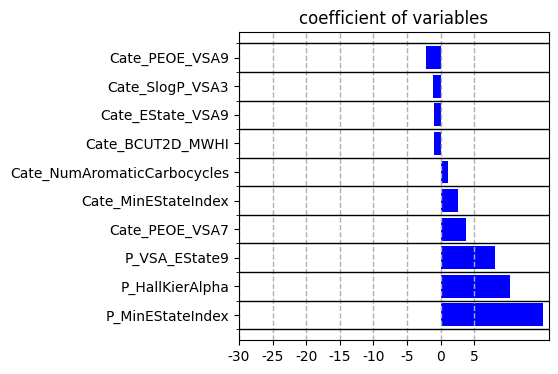

In [12]:
x_pos = np.arange(len(chart))

fig = plt.figure(figsize=(4,4))
ax1 = fig.add_subplot(1, 1, 1)
ax1.barh(x_pos, chart['standard_regression_coefficients'], color='b')
ax1.set_title('coefficient of variables')
ax1.set_yticks(x_pos)
ax1.set_yticks(np.arange(-1,len(chart.index))+0.5, minor=True)
ax1.set_yticklabels(chart.index)
ax1.set_xticks(np.arange(-30,10,5))
ax1.set_xticklabels(np.arange(-30,10,5))
ax1.grid(which='minor',axis='y',color='black',linestyle='-', linewidth=1)
ax1.grid(which='major',axis='x',linestyle='--', linewidth=1)
plt.show()